In [1]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
np.random.seed(1234)

from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn
seaborn.set_style("white")
seaborn.set_context("paper")

from hips.plotting.layout import create_axis_at_location

plt.ion()

from tqdm import tqdm
from functools import partial

from zimmer.io import load_nichols_data, load_kato_data
import zimmer.plotting as zplt
from zimmer.util import cached

from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter, standardize

In [5]:
# Specify hyperparameters
results_dir = "results/kato/2018-10-10/"
figures_dir = os.path.join(results_dir, "figures")

In [3]:
ys, ms, z_trues, z_true_key, neuron_names = \
    load_kato_data(include_unnamed=False, signal="dff")

Only including named neurons.
59 neurons across all 5 worms


In [193]:
ys = [trend_filter(y, npoly=1, nexp=0) for y in ys]
# ys = [standardize(y, m) for y, m in zip(ys, ms)]
# K_true = len(z_true_key)
K_true = 8
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

# Empirical correlation

In [194]:
def compute_correlation():
    C = np.nan * np.ones((N, N))
    
    for i in range(N):
        for j in range(N):
            Ei, Ej, Eii, Ejj, Eij = 0, 0, 0, 0, 0
            n = 0
            for y, m in zip(ys, ms):
                if not np.any(m[:,i] & m[:, j]):
                    continue
                inds = m[:, i] & m[:, j]
                Ei += np.sum(y[inds, i])
                Ej += np.sum(y[inds, j])
                Eii += np.sum(y[inds, i] * y[inds, i])
                Ejj += np.sum(y[inds, j] * y[inds, j])
                Eij += np.sum(y[inds, i] * y[inds, j])
                n += np.sum(inds.astype(int))
            
            if n > 0:
                Ei /= n
                Ej /= n
                Eii /= n
                Ejj /= n
                Eij /= n
                C[i, j] = (Eij - Ei * Ej) / np.sqrt(Eii - Ei**2) / np.sqrt(Ejj - Ej**2)
    
    return C

_corr = cached(results_dir, "corr")(compute_correlation)
emp_corr = _corr()
                

# PCA 

In [199]:
with open("results/kato/2018-10-09/D10/pca.pkl", "rb") as f:
    pca, x_fulls = pickle.load(f)

In [200]:
# # Run PCA to get a 3d projection of the data
# from ssm.preprocessing import pca_with_imputation
# # _pca = cached(results_dir, "pca_D{}".format(20))(pca_with_imputation)
# _pca = pca_with_imputation
# pca, x_fulls = _pca(20, ys, ms, num_iters=100)

In [ ]:
# Determine number of PCs to use
plt.plot(np.arange(1, pca.n_components+1), np.cumsum(pca.explained_variance_ratio_), '-o')
plt.plot(np.arange(1, pca.n_components+1), 0.9 * np.ones(pca.n_components), ':k')
plt.xlabel("D")
plt.ylabel("% var. explained")
plt.ylim(0,1)
plt.xticks(np.arange(pca.n_components))
plt.xlim(1, pca.n_components)

In [205]:
D = 10
xs = [x[:,:D] for x in x_fulls]

In [206]:
# To compute the correlation under the PCA model, we need the covariance of the PCA embeddings
C_pca = pca.components_.T[:, :D]
L_x = np.linalg.cholesky(np.cov(np.vstack(xs).T))
C_pca = C_pca.dot(L_x)
Cn_pca = C_pca / np.linalg.norm(C_pca, ord=2, axis=1, keepdims=True)
pca_corr = Cn_pca.dot(Cn_pca.T)

# Factor Analysis

In [207]:
# # Fit a test model
# def fit_factor_analysis(D, num_gibbs_iters=20, num_em_iters=100):
    
#     # Special case D == 0
#     if D == 0:
#         mu = np.zeros(N)
#         Sigma = np.diag(np.nanvar(np.vstack(train_ys), axis=0))
        
#         lp = 0
#         for y, m in zip(train_ys, train_ms):
#             mu_i = mu[m[0]]
#             Sigma_i = Sigma[np.ix_(m[0], m[0])]
#             lp += np.sum(multivariate_normal.logpdf(y[:, m[0]], mu_i, Sigma_i))
        
#         val_ll = 0
#         for y, m in zip(val_ys, val_ms):
#             mu_i = mu[m[0]]
#             Sigma_i = Sigma[np.ix_(m[0], m[0])]
#             val_ll += np.sum(multivariate_normal.logpdf(y[:, m[0]], mu_i, Sigma_i))
        
#         return Sigma, np.array([lp]), val_ll
        
#     # For D > 1, fit a factor analysis model
#     from pybasicbayes.models import FactorAnalysis
#     fa = FactorAnalysis(N, D)
#     for y, m in zip(train_ys, train_ms):
#         fa.add_data(y, mask=m.astype(bool))

#     lps = []
#     for _ in tqdm(range((num_gibbs_iters))):
#         fa.resample_model()
#         lps.append(fa.log_likelihood())

#     for _ in tqdm(range((num_em_iters))):
#         fa.EM_step()
#         lps.append(fa.log_likelihood())

#     # Compute marginal likelihood of validation data
#     mu = np.zeros(N)
#     Sigma = fa.W.dot(fa.W.T) + np.diag(fa.sigmasq)
    
#     val_ll = 0
#     for y, m in zip(val_ys, val_ms):
#         m0 = m[0]
#         mu_i = mu[m0]
#         Sigma_i = Sigma[np.ix_(m0, m0)]
#         vll = multivariate_normal.logpdf(y[:, m0], mu_i, Sigma_i)
#         assert vll.shape == (y.shape[0],)
#         val_ll += np.sum(vll)
    
#     return fa, lps, val_ll

# Ds = [10]
# fas = []
# lpss = []
# val_lls = []
# for D in Ds:
#     print("Fitting FA with D=", D)
#     _fa = cached(results_dir, "fa_D{}".format(D))(fit_factor_analysis)
#     fa, lps, val_ll = _fa(D)
#     fas.append(fa)
#     lpss.append(lps)
#     val_lls.append(val_ll)

In [208]:
# for D, lps in zip(Ds, lpss):
#     plt.plot(lps, label="D={}".format(D))
# #     plt.xlim(21, 120)
# plt.legend()

# plt.figure()
# plt.plot(Ds, val_lls)
# ll_95 = np.min(val_lls[1:]) + 0.95 * (np.max(val_lls) - np.min(val_lls[1:]))
# plt.plot(Ds, ll_95 * np.ones_like(Ds), ':k')
# plt.legend()

In [209]:
# # Find an orthogonal emission matrix from the factor analysis loadings
# C_fa = fa.W
# Sigma = np.dot(C_fa, C_fa.T) + np.diag(fa.sigmasq)
# evals, evecs = np.linalg.eigh(Sigma, )
# inds = np.argsort(evals)[::-1][:D]
# Cstar_fa = evecs[:, inds]

# # Find the linear transformation that maps C to Cstar
# #    Cstar = C \dot R
# #    Cstar R^{-1} = C
# #    y = Cx = Cstar R^{-1} x
# R, _, _, _ = np.linalg.lstsq(C_fa, Cstar_fa)
# Ri = np.linalg.inv(R)

# # Counter rotate the continuous latent states
# xs_fa = [d.Z.dot(Ri.T) for d in fa.data_list]

# # Compute the correlation under the FA model
# Cn_fa = C_fa / np.linalg.norm(C_fa, ord=2, axis=1, keepdims=True)
# fa_corr = Cn_fa.dot(Cn_fa.T)

In [210]:
# plt.plot(xs_fa[28] + np.arange(10))

In [211]:
# for w in range(5, W):
#     yw = ys[w].copy()
#     yw[~ms[w]] = np.nan
#     plt.plot(np.nanmean(yw, axis=1), alpha=.25, c='k')

In [212]:
# w_to_plot = np.concatenate((np.arange(5), 5 + 3 + np.array([0, 11, 23, 33])))
# plt.figure(figsize=(12, 4))
# for i, w in enumerate(w_to_plot): 
#     ax = plt.subplot(2, len(w_to_plot), i+1)
#     zplt.plot_2d_continuous_states(xs_fa[w], z_trues[w], xlims=(-2, 2), ylims=(-2, 2), inds=(0, 1), ax=ax)
#     plt.xticks([])
#     plt.yticks([])
    
#     ax = plt.subplot(2, len(w_to_plot), len(w_to_plot) + i+1)
#     zplt.plot_2d_continuous_states(xs_fa[w], z_trues[w], xlims=(-2, 2), ylims=(-2, 2), inds=(0, 2), ax=ax)
#     plt.xticks([])
#     plt.yticks([])

# Cluster the neurons on the basis of their latent state tuning

In [213]:
def cluster_neurons(C_norm, N_clusters, seed):
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score, calinski_harabaz_score
    from sklearn.metrics import davies_bouldin_score
    from sklearn.decomposition import PCA
    from pyhsmm.util.general import relabel_by_permutation
    
    # Perform the clustering
    np.random.seed(seed)    
    cluster = KMeans(n_clusters=N_clusters)
    cluster.fit(C_norm)
    neuron_clusters = cluster.labels_

    # Compute some clustering metrics
    sil_score = silhouette_score(C_norm, neuron_clusters, metric='cosine')
    ch_score = calinski_harabaz_score(C_norm, neuron_clusters)    
    db_score = np.nan
    
    # Reorder the clusters according to average tuning within cluster
    avg_C = np.zeros((N_clusters, D))
    for c in range(N_clusters):
        if not np.any(neuron_clusters == c):
            continue
        avg_C[c] = np.mean(C_norm[neuron_clusters == c], axis=0)

    # Sort the clusters by their projection onto the first principal component
    pca = PCA(n_components=1, random_state=0, svd_solver="full")
    pca.fit(avg_C)
    weights = pca.transform(avg_C)[:, 0]
    weights *= np.sign(weights[0])

    labels_perm = np.argsort(weights)
    neuron_clusters = relabel_by_permutation(neuron_clusters, np.argsort(labels_perm))

    # Lex sort by label then by emission vector
    # perm = np.lexsort(np.row_stack((C_true.T, labels)))
    neuron_perm = np.lexsort((neuron_names, neuron_clusters))
    
    return neuron_perm, neuron_clusters, sil_score, ch_score, db_score

In [215]:
sil_scores = []
ch_scores = []
db_scores = []
Ks = np.arange(2, 21)
N_repeats = 50
for K in Ks:
    print("K = ", K)
    sil_scores_K = []
    ch_scores_K = []
    db_scores_K = []
    for rpt in range(N_repeats):
        _cluster = cached(os.path.join(results_dir, "kmeans"), "kmeans_K{}_rpt{}".format(K, rpt))(cluster_neurons)
        _, _, sil_score, ch_score, db_score = _cluster(Cn_pca, K, seed=rpt)
        sil_scores_K.append(sil_score)
        ch_scores_K.append(ch_score)
        db_scores_K.append(db_score)
    
    sil_scores.append(sil_scores_K)
    ch_scores.append(ch_scores_K)
    db_scores.append(db_scores_K)
    
# Compute mean and variance
mean_sil_scores = [np.mean(ss) for ss in sil_scores]
std_sil_scores = [np.std(ss) for ss in sil_scores]
mean_ch_scores = [np.mean(chs) for chs in ch_scores]
std_ch_scores = [np.std(chs) for chs in ch_scores]
mean_db_scores = [np.mean(dbs) for dbs in db_scores]
std_db_scores = [np.std(dbs) for dbs in db_scores]

K =  2
K =  3
K =  4
K =  5
K =  6
K =  7
K =  8
K =  9
K =  10
K =  11
K =  12
K =  13
K =  14
K =  15
K =  16
K =  17
K =  18
K =  19
K =  20


Text(0.5,1,'Calinski-Harabaz Score (higher = better)')

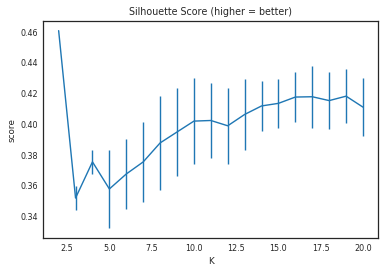

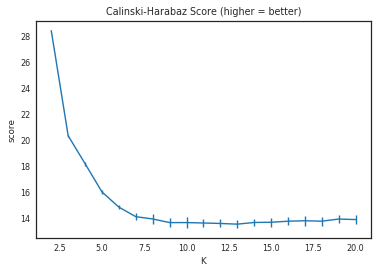

In [216]:
plt.figure()
plt.errorbar(Ks, mean_sil_scores, yerr=std_sil_scores)
plt.xlabel("K")
# plt.xticks(Ks)
plt.ylabel("score")
plt.title("Silhouette Score (higher = better)")

plt.figure()
plt.errorbar(Ks, mean_ch_scores, yerr=std_ch_scores)
plt.xlabel("K")
# plt.xticks(Ks)
plt.ylabel("score")
plt.title("Calinski-Harabaz Score (higher = better)")

In [217]:
print("Best K: ", Ks[np.argmax(mean_sil_scores)])

Best K:  2


In [218]:
best_K = 10
rpt = 0
_cluster = cached(os.path.join(results_dir, "kmeans"), "kmeans_K{}_rpt{}".format(best_K, rpt))(cluster_neurons)
perm, clusters, _, _, _ = _cluster(Cn_pca, best_K, seed=rpt)
divs = np.cumsum(np.bincount(clusters, minlength=best_K))

# Load per neuron location, type, functional type dat

In [221]:
import pandas as pd

neuron_locations_csv = pd.read_csv("~/Projects/zimmer/wormatlas_locations.csv")
neuron_locations = [np.array(neuron_locations_csv[neuron_locations_csv.name == name].location)[0] 
                    for name in neuron_names]
neuron_locations = np.array(neuron_locations)

In [222]:
neuron_celltypes_csv = pd.read_csv("~/Projects/zimmer/wormatlas_celltypes.csv")
celltypes = ['S', 'I', 'M', 'P', 'U']
neuron_celltypes = []
for name in neuron_names:
    neuron_celltypes.append(np.array(neuron_celltypes_csv[neuron_celltypes_csv.name == name].type)[0])
neuron_celltypes = np.array(neuron_celltypes)

In [223]:
neuron_functions_csv = pd.read_csv("~/Projects/zimmer/neuron_functions.csv")
functions = ['Fwd', 'Rev', 'FwdRev', 'DT', 'VT', 'Other', 'Quiescence', 'FwdQui', 'Sensory']
neuron_functions = []
for name in neuron_names:
    row = neuron_functions_csv[neuron_functions_csv.Name == name]
    assert len(row) == 1
    for f in functions:
        if np.array(row[f])[0] == 1:
            neuron_functions.append(f)
neuron_functions = np.array(neuron_functions)

# Make Figure 2: C matrix, Raw Correlation, Estimated Correlation

In [224]:
def _plot_corr(ax, corr, cmap):
    im = plt.imshow(corr[np.ix_(perm, perm)], cmap=cmap, vmin=-1, vmax=1, extent=(0, N, N, 0), aspect="auto")
    for div in divs:
        plt.plot([0, N], [div, div], '-k', lw=.5)
        plt.plot([div, div], [0, N], '-k', lw=.5)
    plt.xlim(0, N)
    plt.ylim(N, 0)
    return im

In [225]:
# Set colors for each function
functions = ['Fwd', 'Rev', 'FwdRev', 'DT', 'VT', 'Quiescence', 'FwdQui', 'Sensory', 'Other']
short_functions = ['Fwd', 'Rev', 'FR', 'DT', 'VT', 'Q', 'FQ', 'O$_2$', 'Unk']
func_colors = [zplt.default_colors[1], # fwd = red
          zplt.default_colors[0], # rev = blue
          "navy",                 # fwd/rev = navy
          zplt.default_colors[3], # dt = yellow
          zplt.default_colors[2], # vt = Green
          zplt.default_colors[4], # quiescence = purple
          'maroon',                 # fwdqui = maroon
          zplt.default_colors[7], # sensory = pink
          zplt.default_colors[8], # other = Grey
         ]

func_color_dict = dict(zip(functions, func_colors))

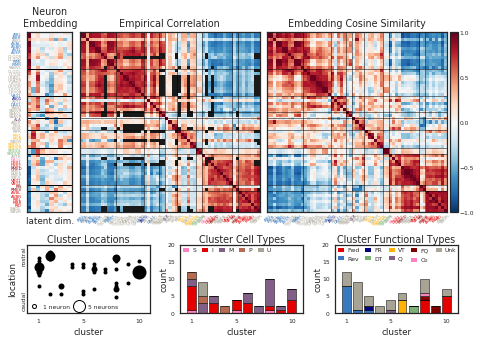

In [277]:
cmap = matplotlib.cm.RdBu_r
cmap.set_bad(.1 * np.ones(3), 1.)

# Make plot
fig = plt.figure(figsize=(6.5, 4.75))
fig.patch.set_alpha(0)

# Plot C
lim = abs(Cn_pca).max()
ax = create_axis_at_location(fig, .275, 1.8, .625, 2.5)
plt.imshow(Cn_pca[perm], vmin=-lim, vmax=lim, cmap="RdBu_r", extent=(0, D, N, 0), aspect="auto")
for div in divs:
    plt.plot([0, D], [div, div], '-k', lw=1)
plt.xlim(0, D)
plt.xticks([])
plt.ylim(N, 0)

# Only put ticks at the locations of neurons with known functions
perm_names = neuron_names[perm]
perm_functions = neuron_functions[perm]
# known_inds = np.where(perm_functions != 'Other')[0]
known_inds = np.arange(N)
known_neurons = perm_names[known_inds]
known_functions = perm_functions[known_inds]
plt.yticks(known_inds + .5, known_neurons, fontsize=4)
assert len(ax.yaxis.get_ticklabels()) == len(known_neurons)
for tl, fn in zip(ax.yaxis.get_ticklabels(), known_functions):
    tl.set_color(func_color_dict[fn])
#plt.yticks(np.arange(N)+.5, neuron_names[perm], fontsize=3)
plt.xlabel("latent dim.")
plt.title("Neuron\nEmbedding")

# Plot empirical correlation
ax = create_axis_at_location(fig, 1, 1.8, 2.5, 2.5)
im = _plot_corr(ax, emp_corr, cmap)
ax.set_yticks([])
plt.xticks(known_inds + .5, known_neurons, fontsize=4, rotation=45)
ax.tick_params(axis='x', which='major', pad=1)
for tl, fn in zip(ax.xaxis.get_ticklabels(), known_functions):
    tl.set_color(func_color_dict[fn])
plt.title("Empirical Correlation")

# Plot model correlation
ax = create_axis_at_location(fig, 3.6, 1.8, 2.5, 2.5)
im = _plot_corr(ax, pca_corr, cmap)
ax.set_xticks([])
ax.set_yticks([])
plt.xticks(known_inds + .5, known_neurons, fontsize=4, rotation=45)
ax.tick_params(axis='x', which='major', pad=1)
for tl, fn in zip(ax.xaxis.get_ticklabels(), known_functions):
    tl.set_color(func_color_dict[fn])
plt.title("Embedding Cosine Similarity")

# Colorbar
cbax = create_axis_at_location(fig, 6.15, 1.8, .1, 2.5)
plt.colorbar(im, cbax, ticks=[-1, -.5, 0, .5, 1])
cbax.tick_params(labelsize=6, pad=2)

# Cluster locations
xticks = np.concatenate(([0], np.arange(4, best_K+1, step=5)))
xticklabels = xticks + 1
ax = create_axis_at_location(fig, .275, .4, 1.7, .95)
location_bins = np.arange(neuron_locations.min(), neuron_locations.max()+.01, .01)
for k in range(best_K):
    locs_k, _ = np.histogram([l for l, c in zip(neuron_locations, clusters) if c == k], location_bins)
    
    for b, count in zip(location_bins, locs_k):
        if count > 0:
            plt.plot(k, b, 'ko', markersize=2 + 2 * count)
        
# Make dummy legend
plt.plot(-1, -1, 'ko', ms=4, mfc='w', mec='k', mew=1, label="1 neuron")
plt.plot(-1, -1, 'ko', ms=2 + 2 * 5, mfc='w', mec='k', mew=1, label="5 neurons")
plt.legend(ncol=5, loc="lower left", handlelength=1, handletextpad=1, columnspacing=1, fontsize=6, borderaxespad=.25)
        
plt.xticks(xticks, xticklabels, fontsize=6)
plt.xlabel("cluster")
plt.xlim(-1, best_K)
# plt.yticks(np.arange(0.05, 0.31, 0.05), fontsize=6)
plt.yticks([.225, .06], ["caudal", "rostral"], rotation=90, fontsize=6)
ax.tick_params(axis='y', which='major', pad=1)
plt.ylim(.30, .05)
plt.ylabel("location")
plt.title("Cluster Locations", y=.95)

# Cluster cell types
type_colors = [zplt.default_colors[7], zplt.default_colors[1], zplt.default_colors[4], zplt.default_colors[6], zplt.default_colors[8]]
ax = create_axis_at_location(fig, 2.4, .4, 1.7, .95)
for k in range(best_K):
    offset = 0
    for i, t in enumerate(celltypes):
        count = np.sum(neuron_celltypes[clusters == k] == t)
        plt.bar(k, count, width=.8, bottom=offset, color=type_colors[i], edgecolor='k', linewidth=.5)
        offset += count
        
# Make dummy legend
for i, t in enumerate(celltypes):
    plt.bar(-1, 0, width=0, color=type_colors[i], label=t)
plt.legend(ncol=5, loc="upper left", handlelength=1, handletextpad=.5, columnspacing=1, fontsize=6, borderaxespad=.1)
        
plt.xticks(xticks, xticklabels, fontsize=6)
plt.xlabel("cluster")
plt.xlim(-1, best_K)
plt.yticks(np.arange(0, 21, 5), fontsize=6)
plt.ylabel("count", labelpad=-1)
plt.ylim(0, 20)
plt.title("Cluster Cell Types", y=.95)

# Cluster functional types
ax = create_axis_at_location(fig, 4.55, .4, 1.7, .95)
for k in range(best_K):
    offset = 0
    for i, t in enumerate(functions):
        count = np.sum(neuron_functions[clusters == k] == t)
        plt.bar(k, count, width=.8, bottom=offset, color=func_colors[i], edgecolor='k', linewidth=.5)
        offset += count

# Make dummy legend
for i, t in enumerate(short_functions):
    plt.bar(-1, 0, width=0, color=func_colors[i], label=t)
plt.legend(ncol=5, loc="upper left", handlelength=1, handletextpad=.5, columnspacing=1, fontsize=6, borderaxespad=.1)
        
plt.xticks(xticks, xticklabels, fontsize=6)
plt.xlabel("cluster")
plt.xlim(-1, best_K)
plt.yticks(np.arange(0, 21, 5), fontsize=6)
plt.ylabel("count", labelpad=-1)
plt.ylim(0, 20)
plt.title("Cluster Functional Types", y=.95)


figname = "2_clustering"
plt.savefig(os.path.join(figures_dir, figname + ".png"), dpi=300)
plt.savefig(os.path.join(figures_dir, figname + ".pdf"))

# Supplementary Figure

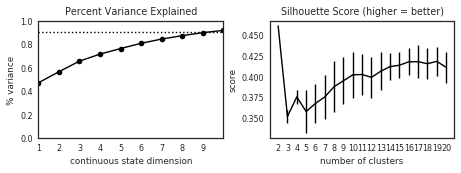

In [237]:
# Determine number of PCs to use
plt.figure(figsize=(6.5, 2.5))
plt.subplot(121)
plt.plot(np.arange(1, pca.n_components+1), np.cumsum(pca.explained_variance_ratio_), '-ko')
plt.plot(np.arange(1, pca.n_components+1), 0.9 * np.ones(pca.n_components), ':k')
plt.xlabel("continuous state dimension")
plt.ylim(0,1)
plt.ylabel("% variance")
plt.xticks(np.arange(pca.n_components))
plt.xlim(1, pca.n_components)
plt.title("Percent Variance Explained")

plt.subplot(122)
plt.errorbar(Ks, mean_sil_scores, yerr=std_sil_scores, color='k', ecolor='k')
plt.xlabel("number of clusters")
plt.xticks(Ks)
plt.ylabel("score")
plt.title("Silhouette Score (higher = better)")

plt.tight_layout()

plt.savefig(os.path.join(figures_dir, "s2_dim_reduction.pdf"))
plt.savefig(os.path.join(figures_dir, "s2_dim_reduction.png"), dpi=300)

# Save the results

In [228]:
results = dict(
    perm=perm,
    neuron_clusters=clusters,
    neuron_names=neuron_names,
    neuron_locations=neuron_locations,
    celltypes=celltypes,
    neuron_celltypes=neuron_celltypes,
    functions=functions,
    short_functions=short_functions,
    func_color_dict=func_color_dict,
    neuron_functions=neuron_functions,
    C=pca.components_.T,
    d=pca.mean_
)

with open(os.path.join(results_dir, "summary.pkl"), "wb") as f:
    pickle.dump(results, f)